In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import average_precision_score, confusion_matrix
import sys
sys.path.append('../')
from src.utils.metrics.true_skill_statistic import vectorized_true_skill_statistic

%matplotlib inline

In [2]:
colors = {
    "yellow": "#EBB53D",
    "green": "#3B916D",
    "orange": "#DE8945",
    "blue": "#39909E",
    "red": "#EB4336",
    "black": "#231F20",
    "beige": "#EFEADF",
    "leafgreen": "#8CA530",
    "softmint": "#C3D9BF"
}

cm_to_inch = 1/2.54

onecolumn = 8.8 * cm_to_inch
twocolumn = 17.6 * cm_to_inch
onehalfcolumn = 13.2 * cm_to_inch

# Three row figure
# Set font to FiraCode NF (can remove if you don't have the font, not essential)
plt.rcParams["font.family"] = "FiraCode Nerd Font"

# Set all base black colors to my colors["black"]
plt.rcParams["text.color"] = colors["black"]
plt.rcParams["axes.labelcolor"] = colors["black"]
plt.rcParams["xtick.color"] = colors["black"]
plt.rcParams["ytick.color"] = colors["black"]
plt.rcParams["axes.edgecolor"] = colors["black"]


# Splits characterization table

In [3]:
# Connect to the features database
sdb_path = "../data/features.db"
sconn = sqlite3.connect(sdb_path)
scur = sconn.cursor()

# List all tables for reference
scur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(scur.fetchall())

[('DATASETS',), ('SWAN',), ('keywords_desc',), ('padded_features',), ('TESTING_TABLE',), ('T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset',), ('T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset_splits',)]


In [4]:
table = "T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset"

In [5]:
data = pd.read_sql(f"""
SELECT 
  split,
  COUNT(DISTINCT harpnum) AS n_unique_harpnum,
  COUNT(*) AS n_examples,
  SUM(CASE WHEN has_flare_above_threshold = 1 THEN 1 ELSE 0 END) AS n_flare_above_threshold_examples,
  SUM(CASE WHEN has_flare_below_threshold = 1 THEN 1 ELSE 0 END) AS n_flare_below_threshold_examples,
  SUM(CASE WHEN has_cme_flare_above_threshold = 1 THEN 1 ELSE 0 END) AS n_cme_flare_above_threshold_examples,
  SUM(CASE WHEN has_cme_flare_below_threshold = 1 THEN 1 ELSE 0 END) AS n_cme_flare_below_threshold_examples,
  COUNT(DISTINCT CASE WHEN has_flare_above_threshold = 1 THEN harpnum END) AS n_unique_harpnum_flare_above_threshold,
  COUNT(DISTINCT CASE WHEN has_flare_below_threshold = 1 THEN harpnum END) AS n_unique_harpnum_flare_below_threshold,
  COUNT(DISTINCT CASE WHEN has_cme_flare_above_threshold = 1 THEN harpnum END) AS n_unique_harpnum_cme_flare_above_threshold,
  COUNT(DISTINCT CASE WHEN has_cme_flare_below_threshold = 1 THEN harpnum END) AS n_unique_harpnum_cme_flare_below_threshold,
  COUNT(DISTINCT CASE WHEN is_flare_active = 1 THEN harpnum END) AS n_unique_harpnum_flare_active,
  COUNT(DISTINCT CASE WHEN is_flare_active = 0 THEN harpnum END) AS n_unique_harpnum_no_flare_active,
  COUNT(DISTINCT CASE WHEN is_cme_active = 1 THEN harpnum END) AS n_unique_harpnum_cme_active,
  COUNT(DISTINCT CASE WHEN is_cme_active = 0 THEN harpnum END) AS n_unique_harpnum_no_cme_active,
  COUNT(DISTINCT flare_above_threshold_id) AS n_unique_flare_above_threshold,
  COUNT(DISTINCT flare_below_threshold_id) AS n_unique_flare_below_threshold,
  COUNT(DISTINCT cme_flare_above_threshold_id) AS n_unique_cme_flare_above_threshold,
  COUNT(DISTINCT cme_flare_below_threshold_id) AS n_unique_cme_flare_below_threshold
FROM (
  SELECT 
    d.*,
    s.split,
    s.is_active as is_flare_active,
    s.is_cme_active as is_cme_active
  FROM {table} d
  INNER JOIN {table}_splits s
  ON d.harpnum = s.harpnum
) AS subquery
GROUP BY split;
""", sconn)

data["n_cme_examples"] = data["n_cme_flare_above_threshold_examples"] + data["n_cme_flare_below_threshold_examples"]
data["n_unique_cme"] = data["n_unique_cme_flare_above_threshold"] + data["n_unique_cme_flare_below_threshold"]
data["n_unique_harpnum_cme"] = data["n_unique_harpnum_cme_flare_above_threshold"] + data["n_unique_harpnum_cme_flare_below_threshold"]

data

,split,n_unique_harpnum,n_examples,n_flare_above_threshold_examples,n_flare_below_threshold_examples,n_cme_flare_above_threshold_examples,n_cme_flare_below_threshold_examples,n_unique_harpnum_flare_above_threshold,n_unique_harpnum_flare_below_threshold,n_unique_harpnum_cme_flare_above_threshold,...,n_unique_harpnum_no_flare_active,n_unique_harpnum_cme_active,n_unique_harpnum_no_cme_active,n_unique_flare_above_threshold,n_unique_flare_below_threshold,n_unique_cme_flare_above_threshold,n_unique_cme_flare_below_threshold,n_cme_examples,n_unique_cme,n_unique_harpnum_cme
0,0,302,170457,2696,24998,855,3692,14,69,8,...,233,34,268,46,638,9,44,4547,53,36
1,1,279,152986,2816,29469,799,3572,16,75,8,...,204,29,250,44,761,13,41,4371,54,31
2,2,279,145689,3824,24732,1286,3309,16,54,12,...,225,24,255,51,601,13,38,4595,51,32
3,3,269,152925,3435,24739,1446,3082,11,66,7,...,203,32,237,46,590,13,34,4528,47,33
4,4,309,167068,2805,26343,1131,3231,16,69,7,...,240,32,277,37,618,13,39,4362,52,37
5,5,290,152920,3241,23815,804,3843,21,57,5,...,233,24,266,45,543,12,41,4647,53,29
6,6,294,152657,3047,19584,1328,2922,13,50,5,...,244,18,276,47,495,21,41,4250,62,23
7,7,278,153449,2444,21857,739,3389,8,56,2,...,222,25,253,49,593,13,44,4128,57,27
8,8,301,160278,2900,22768,1090,2843,14,60,8,...,241,26,275,45,605,13,35,3933,48,30
9,9,280,149549,3001,21480,971,3675,13,50,5,...,230,20,260,46,577,13,46,4646,59,24


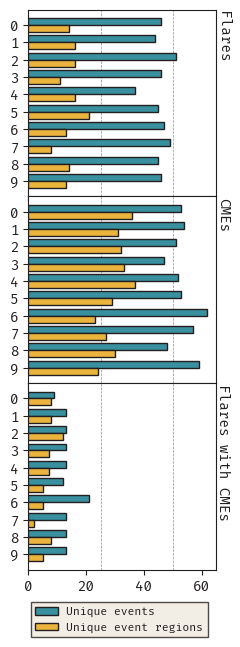

In [7]:
# Three row figure
# Set font to FiraCode NF
plt.rcParams["font.family"] = "FiraCode Nerd Font"

# Set all base black colors to my colors["black"]
plt.rcParams["text.color"] = colors["black"]
plt.rcParams["axes.labelcolor"] = colors["black"]
plt.rcParams["xtick.color"] = colors["black"]
plt.rcParams["ytick.color"] = colors["black"]
plt.rcParams["axes.edgecolor"] = colors["black"]

fig, axes = plt.subplots(3, 1, figsize=(0.7 * onecolumn, 2.1 * onecolumn), sharex=True)

# Remove vertical space between subplots
plt.subplots_adjust(hspace=0)

for ax in axes:
    # Set y ticks to 1 to 10 with step 1
    ax.set_yticks(np.arange(0, 10, 1))

column_names = (
("n_unique_flare_above_threshold", "n_unique_harpnum_flare_above_threshold"),
("n_unique_cme", "n_unique_harpnum_cme"),
("n_unique_cme_flare_above_threshold", "n_unique_harpnum_cme_flare_above_threshold")
)
fig_names = ("Flares", "CMEs", "Flares with CMEs")

for i in range(3):
    ax = axes[i]

    ax.set_title(fig_names[i], fontsize=10, rotation=-90,ha='left', va='top', y=0.95, x=1)

    # Invert y-axis
    ax.invert_yaxis()

    # Vertical grid at 0, 25 and 50
    ax.axvline(x=25, color=colors["black"], linewidth=0.5, linestyle="--", alpha=0.5, zorder=0, label="_nolegend_")
    ax.axvline(x=50, color=colors["black"], linewidth=0.5, linestyle="--", alpha=0.5, zorder=0, label="_nolegend_")

    # Horizontal bars with number of flares per split
    ax.barh(data["split"]-0.2, data[column_names[i][0]], color=colors["blue"], label="Unique Flares", height=0.4, linewidth=1, edgecolor=colors["black"], zorder=10)
    ax.barh(data["split"]+0.2, data[column_names[i][1]], color=colors["yellow"], label="Unique regions with flare", height=0.4, linewidth=1, edgecolor=colors["black"], zorder=10)


# Now a legend below the bottom plot with the colors and "N. unique events" and "N. unique regions with event"
# Create a legend
legend = fig.legend(
    loc="lower center",
    ncol=1,
    labels=["Unique events", "Unique event regions"],
    bbox_to_anchor=(0.5, 0.01),
    bbox_transform=fig.transFigure,
    fancybox=False,
    facecolor=colors["beige"],
    edgecolor=colors["black"],
    fontsize=8
)

plt.savefig("splits_fig.pdf", bbox_inches="tight")

In [8]:
summary_data = data[[
    "split",
    "n_unique_harpnum", 
    "n_examples", 
    "n_flare_above_threshold_examples",
    "n_cme_examples",
    "n_cme_flare_above_threshold_examples",
    ]].copy()

summary_data.rename(columns={
    "split": "Split",
    "n_unique_harpnum": "HARP regions",
    "n_examples": "Total examples",
    "n_flare_above_threshold_examples": "Flare examples",
    "n_cme_examples": "CME examples",
    "n_cme_flare_above_threshold_examples": "CME flare examples",
}, inplace=True)

summary_data.to_latex(index=False, buf="splits_table.tex")

/tmp/ipykernel_3220245/4057374829.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_data.to_latex(index=False, buf="splits_table.tex")


# Model performance tables

In [9]:
preds_path = "../out/main_predictions.db"

conn = sqlite3.connect(preds_path)
cur = conn.cursor()

for table in ["flare_forecast", "cme_forecast", "flare_cme_assoc"]:
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_harpnum_idx ON {table}_rotary_transformer_24_predictions (harpnum)")
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_run_id_idx ON {table}_rotary_transformer_24_predictions (run_id)")

# Attach ../data/features.db

cur.execute("ATTACH DATABASE '../data/features.db' AS features")

# Delete temp view if exists
cur.execute("DROP TABLE IF EXISTS combined_forecasts")

cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_flare_forecast ON flare_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_cme_forecast ON cme_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_flare_cme_assoc ON flare_cme_assoc_rotary_transformer_24_predictions(run_id, harpnum, start);

CREATE TEMP TABLE IF NOT EXISTS combined_forecasts AS
WITH unique_keys AS (
    SELECT run_id, harpnum, start, end FROM flare_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM cme_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM flare_cme_assoc_rotary_transformer_24_predictions
),
combined_data AS (
    SELECT 
        uk.run_id, 
        uk.harpnum, 
        uk.start,
        uk.end,
        f.pred AS flare_pred, f.target AS flare_target,
        c.pred AS cme_pred, c.target AS cme_target,
        fc.pred AS flare_cme_pred, fc.target AS flare_cme_target,
        s.is_cme_active as base_cme_pred,
        s.is_cme_active as base_flare_cme_pred,
        s.is_active as base_flare_pred
    FROM unique_keys uk
    LEFT JOIN flare_forecast_rotary_transformer_24_predictions f ON uk.run_id = f.run_id AND uk.harpnum = f.harpnum AND uk.start = f.start
    LEFT JOIN cme_forecast_rotary_transformer_24_predictions c ON uk.run_id = c.run_id AND uk.harpnum = c.harpnum AND uk.start = c.start
    LEFT JOIN flare_cme_assoc_rotary_transformer_24_predictions fc ON uk.run_id = fc.run_id AND uk.harpnum = fc.harpnum AND uk.start = fc.start
    INNER JOIN features.T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset_splits s ON uk.harpnum = s.harpnum
)
SELECT * FROM combined_data;
""")

In [28]:
def calculate_scores(predictions, base_predictions, true_labels, threshold, doprint=False):
    binary_predictions = (predictions > threshold).astype(int)
    base_binary_predictions = (base_predictions > threshold).astype(int)
    cm = confusion_matrix(true_labels, binary_predictions)
    bcm = confusion_matrix(true_labels, base_binary_predictions)
    TN, FP, FN, TP = cm.ravel()
    BTN, BFP, BFN, BTP = bcm.ravel()

    recall = TP / (TP + FN)
    b_recall = BTP / (BTP + BFN)
    precision = TP / (TP + FP)
    b_precision = BTP / (BTP + BFP)
    acc = (TP + TN) / (TP + TN + FP + FN)
    b_acc = (BTP + BTN) / (BTP + BTN + BFP + BFN)
    bacc = 1/2 * (TP / (TP + FN) + TN / (TN + FP))
    b_bacc = 1/2 * (BTP / (BTP + BFN) + BTN / (BTN + BFP))
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    b_HSS = 2 * (BTP * BTN - BFP * BFN) / ((BTP + BFN) * (BFN + BTN) + (BTP + BFP) * (BFP + BTN))
    TSS = recall - (FP / (FP + TN))
    b_TSS = b_recall - (BFP / (BFP + BTN))
    F1 = 2 * (precision * recall) / (precision + recall)
    b_F1 = 2 * (b_precision * b_recall) / (b_precision + b_recall)
    avg_pres_score = average_precision_score(true_labels, predictions)
    b_avg_pres_score = average_precision_score(true_labels, base_predictions)

    if doprint:
        print(f"Recall: {recall}")
        print(f"Precision: {precision}")
        print(f"Accuracy: {acc}")
        print(f"Balanced Accuracy: {bacc}")
        print(f"Heidke Skill Score: {HSS}")
        print(f"True Skill Statistic: {TSS}")
        print(f"Average Precision Score: {avg_pres_score}")

    return recall, precision, acc, bacc, HSS, TSS, avg_pres_score, b_recall, b_precision, b_acc, b_bacc, b_HSS, b_TSS, b_avg_pres_score, F1, b_F1


In [29]:

def get_independent_metrics(data=None, threshold=None, only_active=False):
    if data is None:
        data = pd.read_sql("""
        SELECT * FROM combined_forecasts
                        """, conn)

    metrics = pd.DataFrame(columns=["run_id", "type", "threshold", "recall", "precision", "accuracy", "balanced_accuracy", "heidke_skill_score", "true_skill_statistic", "average_precision_score", "b_recall", "b_precision", "b_accuracy", "b_balanced_accuracy", "b_heidke_skill_score", "b_true_skill_statistic", "b_average_precision_score", "F1", "b_F1"])

    for run_id in tqdm(data["run_id"].unique()):
        for forecast_type in ["flare", "cme", "flare_cme"]:
            run_data = data[data["run_id"] == run_id]

            if only_active:
                run_data = run_data[run_data[f"base_{forecast_type}_pred"] == 1]

            predictions, true_labels, base_predictions = run_data[[f"{forecast_type}_pred", f"{forecast_type}_target", f"base_{forecast_type}_pred"]].dropna().values.T

            assert len(predictions) == len(true_labels), "Predictions and true labels must have the same length."

            # If threshold is none, calculate TSS for several thresholds and select the one that maximizes TSS
            if threshold is None:
                thresholds = np.arange(0, 1.01, 0.01)
                tss_values = vectorized_true_skill_statistic(true_labels, predictions, thresholds)
                # So as to not overwrite threshold
                use_threshold = thresholds[np.argmax(tss_values)]
            else:
                use_threshold = threshold[forecast_type]

            recall, precision, acc, bacc, HSS, TSS, avg_pres_score, b_recall, b_precision, b_acc, b_bacc, b_HSS, b_TSS, b_avg_pres_score, F1, b_F1 = calculate_scores(predictions, base_predictions, true_labels, use_threshold)
            metrics = pd.concat([metrics, pd.DataFrame({"run_id": run_id, "type": forecast_type, "threshold": use_threshold, "recall": recall, "precision": precision, "accuracy": acc, "balanced_accuracy": bacc, "heidke_skill_score": HSS, "true_skill_statistic": TSS, "average_precision_score": avg_pres_score, "b_recall": b_recall, "b_precision": b_precision, "b_accuracy": b_acc, "b_balanced_accuracy": b_bacc, "b_heidke_skill_score": b_HSS, "b_true_skill_statistic": b_TSS, "b_average_precision_score": b_avg_pres_score, "F1": F1, "b_F1": b_F1}, index=[0])])

    return metrics

def get_combined_metrics(data=None, threshold=None, combine_cme_alone=False):
    if data is None:
        data = pd.read_sql("""
        SELECT * FROM combined_forecasts
                        """, conn)

    metrics = pd.DataFrame(columns=["run_id", "type", "threshold", "recall", "precision", "accuracy", "balanced_accuracy", "heidke_skill_score", "true_skill_statistic", "average_precision_score", "b_recall", "b_precision", "b_accuracy", "b_balanced_accuracy", "b_heidke_skill_score", "b_true_skill_statistic", "b_average_precision_score", "F1", "b_F1"])

    for run_id in tqdm(data["run_id"].unique()):
        for forecast_type in ["cme", "flare_cme"]:
            use_threshold = threshold[forecast_type]
            run_data = data[data["run_id"] == run_id]
            flare_predictions, flare_true_labels, flare_base_predictions = run_data[run_data["flare_target"] == 1][[f"{forecast_type}_pred", f"{forecast_type}_target", f"base_{forecast_type}_pred"]].dropna().values.T
            flare_binary_preds = (flare_predictions > threshold["flare"]).astype(int)
            if forecast_type == "cme":
                # Only take predictions when there's a flare in the next 24 hours. For comparison with the flare-CME association model
                predictions, true_labels, base_predictions = run_data[run_data["flare_target"] == 1][[f"{forecast_type}_pred", f"{forecast_type}_target", f"base_{forecast_type}_pred"]].dropna().values.T
                if combine_cme_alone:
                    predictions = predictions * flare_binary_preds
                print(f"Run ID: {run_id}, Forecast Type: {forecast_type}, Number of predictions: {len(predictions)}")
            else:

                predictions, true_labels, base_predictions = run_data[run_data["flare_target"] == 1][[f"{forecast_type}_pred", f"{forecast_type}_target", f"base_{forecast_type}_pred"]].dropna().values.T

                # Now multiply predictions by the flare predictions. So, if didn't predict a flare, can't predict a CME. (0 * anything = 0)
                predictions = predictions * flare_binary_preds
                print(f"Run ID: {run_id}, Forecast Type: {forecast_type}, Number of predictions: {len(predictions)}")

            assert len(predictions) == len(true_labels), "Predictions and true labels must have the same length."

            recall, precision, acc, bacc, HSS, TSS, avg_pres_score, b_recall, b_precision, b_acc, b_bacc, b_HSS, b_TSS, b_avg_pres_score, F1, b_F1 = calculate_scores(predictions, base_predictions, true_labels, use_threshold)
            metrics = pd.concat([metrics, pd.DataFrame({"run_id": run_id, "type": forecast_type, "threshold": use_threshold, "recall": recall, "precision": precision, "accuracy": acc, "balanced_accuracy": bacc, "heidke_skill_score": HSS, "true_skill_statistic": TSS, "average_precision_score": avg_pres_score, "b_recall": b_recall, "b_precision": b_precision, "b_accuracy": b_acc, "b_balanced_accuracy": b_bacc, "b_heidke_skill_score": b_HSS, "b_true_skill_statistic": b_TSS, "b_average_precision_score": b_avg_pres_score, "F1": F1, "b_F1": b_F1}, index=[0])])

    return metrics

In [12]:
data = pd.read_sql("""
SELECT * FROM combined_forecasts
                    """, conn)

### First step is to get the threshold for each model

In [30]:
metrics = get_independent_metrics(data)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


In [31]:

thresholds = metrics.groupby("type").agg(["mean", "std", "median", "min", "max"])["threshold"]["mean"].to_dict()
thresholds

{'cme': 0.307, 'flare': 0.246, 'flare_cme': 0.45999999999999996}

In [15]:
thresholded_metrics = get_independent_metrics(data, threshold=thresholds)
grouped_thresholded_metrics = thresholded_metrics.groupby("type").agg(["mean", "std"])

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


In [34]:
# Now format for latex, we want only some columns and we wan mean (std)

latex_metrics = {
    "threshold": "Threshold",
    "true_skill_statistic": "TSS",
    "heidke_skill_score": "HSS",
    "average_precision_score": "AP",
    "F1": "F1",
                 }

# MUST HAVE FORMATTING THAT IS A STRING BEING FOR EACH LATEX METRIC MEAN (STD)

latex_thresholded_metrics = grouped_thresholded_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column
for key, value in latex_metrics.items():
    for forecast_type in ["flare", "cme", "flare_cme"]:
        f_data = latex_thresholded_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
latex_thresholded_metrics

# Convert to normal dataframe, type is another column

latex_thresholded_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows
forcast_types = {
    "flare": "Flare",
    "cme": "CME",
    "flare_cme": "Flare-CME"
}

# Rename type to Forecast Type
latex_thresholded_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)
# Rename the rows and order as in forecast_types
latex_thresholded_metrics["Forecast Type"] = latex_thresholded_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows
latex_thresholded_metrics = latex_thresholded_metrics.reindex([1, 0, 2]).reset_index(drop=True)


latex_thresholded_metrics.to_latex(index=False, buf="thresholded_metrics.tex")
latex_thresholded_metrics

/tmp/ipykernel_2498416/3620976278.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
/tmp/ipykernel_2498416/3620976278.py:48: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_thresholded_metrics.to_latex(index=False, buf="thresholded_metrics.tex")


,Forecast Type,Threshold,TSS,HSS,AP
,,,,,
0,Flare,0.25,0.81 (0.05),0.23 (0.02),0.45 (0.07)
1,CME,0.31,0.67 (0.05),0.15 (0.02),0.23 (0.06)
2,Flare-CME,0.46,0.17 (0.08),0.16 (0.08),0.47 (0.07)


In [48]:
# Now same table but with the baseline metrics

latex_metrics = {
    "b_true_skill_statistic": "TSS",
    "b_heidke_skill_score": "HSS",
    "b_average_precision_score": "AP",
                 }

# MUST HAVE FORMATTING THAT IS A STRING BEING FOR EACH LATEX METRIC MEAN (STD)

latex_thresholded_metrics = grouped_thresholded_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column
for key, value in latex_metrics.items():
    for forecast_type in ["flare", "cme", "flare_cme"]:
        f_data = latex_thresholded_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_thresholded_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
latex_thresholded_metrics

# Convert to normal dataframe, type is another column

latex_thresholded_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows
forcast_types = {
    "flare": "Flare",
    "cme": "CME",
    "flare_cme": "Flare-CME"
}

# Rename type to Forecast Type
latex_thresholded_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)
# Rename the rows and order as in forecast_types
latex_thresholded_metrics["Forecast Type"] = latex_thresholded_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows
latex_thresholded_metrics = latex_thresholded_metrics.reindex([1, 0, 2]).reset_index(drop=True)


latex_thresholded_metrics.to_latex(index=False, buf="baseline_metrics.tex")
latex_thresholded_metrics

/tmp/ipykernel_2927840/529571126.py:23: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  latex_thresholded_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
/tmp/ipykernel_2927840/529571126.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_thresholded_metrics.to_latex(index=False, buf="baseline_metrics.tex")


,Forecast Type,TSS,HSS,AP
,,,,
0,Flare,0.67 (0.03),0.07 (0.01),0.06 (0.01)
1,CME,0.87 (0.02),0.26 (0.03),0.17 (0.02)
2,Flare-CME,0.17 (0.11),0.12 (0.08),0.39 (0.04)


In [30]:
# Now same but with combined metrics
combined_metrics = get_combined_metrics(data, threshold=thresholds)
grouped_combined_metrics = combined_metrics.groupby("type").agg(["mean", "std"])

 20%|██        | 2/10 [00:00<00:00, 15.32it/s]

Run ID: 0, Forecast Type: cme, Number of predictions: 5512
Run ID: 0, Forecast Type: flare_cme, Number of predictions: 5512
Run ID: 1, Forecast Type: cme, Number of predictions: 6640
Run ID: 1, Forecast Type: flare_cme, Number of predictions: 6640
Run ID: 2, Forecast Type: cme, Number of predictions: 7150
Run ID: 2, Forecast Type: flare_cme, Number of predictions: 7259
Run ID: 3, Forecast Type: cme, Number of predictions: 6066


 60%|██████    | 6/10 [00:00<00:00, 15.06it/s]

Run ID: 3, Forecast Type: flare_cme, Number of predictions: 6240
Run ID: 4, Forecast Type: cme, Number of predictions: 5981
Run ID: 4, Forecast Type: flare_cme, Number of predictions: 6046
Run ID: 5, Forecast Type: cme, Number of predictions: 6288
Run ID: 5, Forecast Type: flare_cme, Number of predictions: 6288
Run ID: 6, Forecast Type: cme, Number of predictions: 5491
Run ID: 6, Forecast Type: flare_cme, Number of predictions: 5491


100%|██████████| 10/10 [00:00<00:00, 15.08it/s]

Run ID: 7, Forecast Type: cme, Number of predictions: 5336
Run ID: 7, Forecast Type: flare_cme, Number of predictions: 5344
Run ID: 8, Forecast Type: cme, Number of predictions: 5893
Run ID: 8, Forecast Type: flare_cme, Number of predictions: 5901
Run ID: 9, Forecast Type: cme, Number of predictions: 5697
Run ID: 9, Forecast Type: flare_cme, Number of predictions: 5697


In [35]:
# Now format for latex, we want only some columns and we wan mean (std)

latex_combined_metrics = grouped_combined_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column

for key, value in latex_metrics.items():
    for forecast_type in ["cme", "flare_cme"]:
        f_data = latex_combined_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_combined_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_combined_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
latex_combined_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)

# Convert to normal dataframe, type is another column
latex_combined_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows
forcast_types = {
    "cme": "CME",
    "flare_cme": "Flare + Flare-CME"
}

# Rename type to Forecast Type
latex_combined_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)

# Rename the rows and order as in forecast_types
latex_combined_metrics["Forecast Type"] = latex_combined_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows
latex_combined_metrics = latex_combined_metrics.reindex([0, 1]).reset_index(drop=True)

latex_combined_metrics.to_latex(index=False, buf="combined_metrics.tex")
latex_combined_metrics

/tmp/ipykernel_2498416/1964204348.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  latex_combined_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
/tmp/ipykernel_2498416/1964204348.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_combined_metrics.to_latex(index=False, buf="combined_metrics.tex")


,Forecast Type,Threshold,TSS,HSS,AP
,,,,,
0,CME,0.31,0.00 (0.02),0.00 (0.02),0.51 (0.11)
1,Flare + Flare-CME,0.46,0.17 (0.08),0.16 (0.08),0.46 (0.07)


In [36]:
# Finally, only_active metrics

only_active_metrics = get_independent_metrics(data, threshold=thresholds, only_active=True)
grouped_only_active_metrics = only_active_metrics.groupby("type").agg(["mean", "std"])

100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


In [37]:
# Now format for latex, we want only some columns and we wan mean (std)

latex_only_active_metrics = grouped_only_active_metrics[[metric for metric in latex_metrics.keys()]].copy()

# Create new formatted column

for key, value in latex_metrics.items():
    for forecast_type in ["flare", "cme", "flare_cme"]:
        f_data = latex_only_active_metrics.loc[forecast_type, key]
        if key == "threshold":
            latex_only_active_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f}"
            continue
        latex_only_active_metrics.loc[forecast_type, f"{value}"] = f"{float(f_data['mean']):.2f} ({float(f_data['std']):.2f})"

# Drop old columns
        
latex_only_active_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)

# Convert to normal dataframe, type is another column

latex_only_active_metrics.reset_index(inplace=True)

# Rename Forecast Type as follows

forcast_types = {
    "flare": "Flare",
    "cme": "CME",
    "flare_cme": "Flare-CME"
}

# Rename type to Forecast Type
latex_only_active_metrics.rename(columns={"type": "Forecast Type"}, inplace=True)

# Rename the rows and order as in forecast_types
latex_only_active_metrics["Forecast Type"] = latex_only_active_metrics["Forecast Type"].map(forcast_types)

# Reorder the rows

latex_only_active_metrics = latex_only_active_metrics.reindex([1, 0, 2]).reset_index(drop=True)

latex_only_active_metrics.to_latex(index=False, buf="only_active_metrics.tex")
latex_only_active_metrics

/tmp/ipykernel_2498416/3993721709.py:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  latex_only_active_metrics.drop(list(latex_metrics.keys()), axis=1, inplace=True)
/tmp/ipykernel_2498416/3993721709.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_only_active_metrics.to_latex(index=False, buf="only_active_metrics.tex")


,Forecast Type,Threshold,TSS,HSS,AP
,,,,,
0,Flare,0.25,0.61 (0.05),0.18 (0.02),0.46 (0.08)
1,CME,0.31,0.21 (0.04),0.10 (0.02),0.29 (0.06)
2,Flare-CME,0.46,0.13 (0.10),0.13 (0.10),0.49 (0.06)


# Ratio of event active to event quiet regions

In [13]:
# Get the number of event active regions in total. We need to see

flare_harpnums = data[~data["flare_target"].isna()]["harpnum"].unique()
cme_harpnums = data[~data["cme_target"].isna()]["harpnum"].unique()
flare_cme_harpnums = data[~data["flare_cme_target"].isna()]["harpnum"].unique()

print(f"Number of unique HARP regions in flares dataset: {len(flare_harpnums)}")
print(f"Number of unique HARP regions in CMEs dataset: {len(cme_harpnums)}")
print(f"Number of unique HARP regions inj flare-CME dataset: {len(flare_cme_harpnums)}")

Number of unique HARP regions in flares dataset: 2881
Number of unique HARP regions in CMEs dataset: 2881
Number of unique HARP regions inj flare-CME dataset: 142


In [14]:
activity_data = pd.read_sql("""
SELECT * FROM features.T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset_splits
""", conn)

activity_data.head()

,split,is_active,is_cme_active,harpnum
0,0,1,1,8
1,0,1,0,12
2,0,0,0,17
3,0,0,0,20
4,0,0,0,36


In [31]:
# Now count for each, the number of active and non active. For flares this is using is_active. For cmes and flare-cme this is is_cme_active

# Using only the harpnums in the each dataset

flare_active = activity_data[activity_data["harpnum"].isin(flare_harpnums)]["is_active"].value_counts()
flare_active_regions = activity_data[activity_data["harpnum"].isin(flare_harpnums) & (activity_data["is_active"] == 1)]["harpnum"].unique()
flare_non_active_regions = activity_data[activity_data["harpnum"].isin(flare_harpnums) & (activity_data["is_active"] == 0)]["harpnum"].unique()

cme_active = activity_data[activity_data["harpnum"].isin(cme_harpnums)]["is_cme_active"].value_counts()
cme_active_regions = activity_data[activity_data["harpnum"].isin(cme_harpnums) & (activity_data["is_cme_active"] == 1)]["harpnum"].unique()
cme_non_active_regions = activity_data[activity_data["harpnum"].isin(cme_harpnums) & (activity_data["is_cme_active"] == 0)]["harpnum"].unique()

flare_cme_active = activity_data[activity_data["harpnum"].isin(flare_cme_harpnums)]["is_cme_active"].value_counts()
flare_cme_active_regions = activity_data[activity_data["harpnum"].isin(flare_cme_harpnums) & (activity_data["is_cme_active"] == 1)]["harpnum"].unique()
flare_cme_non_active_regions = activity_data[activity_data["harpnum"].isin(flare_cme_harpnums) & (activity_data["is_cme_active"] == 0)]["harpnum"].unique()

flare_active_ratio = flare_active[1] / (flare_active[1] + flare_active[0])
cme_active_ratio = cme_active[1] / (cme_active[1] + cme_active[0])
flare_cme_active_ratio = flare_cme_active[1] / (flare_cme_active[1] + flare_cme_active[0])

n_flare_active = len(flare_active_regions)
n_cme_active = len(cme_active_regions)
n_flare_cme_active = len(flare_cme_active_regions)

n_tot_flare = len(flare_harpnums)
n_tot_cme = len(cme_harpnums)
n_tot_flare_cme = len(flare_cme_harpnums)

print(f"Number of active regions in flares dataset: {flare_active[1]}")
print(f"Number of non-active regions in flares dataset: {flare_active[0]}")
print(f"Ratio of active regions in flares dataset: {flare_active_ratio}")

print("\n")

print(f"Number of active regions in CMEs dataset: {cme_active[1]}")
print(f"Number of non-active regions in CMEs dataset: {cme_active[0]}")
print(f"Ratio of active regions in CMEs dataset: {cme_active_ratio}")

print("\n")

print(f"Number of active regions in flare-CME dataset: {flare_cme_active[1]}")
print(f"Number of non-active regions in flare-CME dataset: {flare_cme_active[0]}")
print(f"Ratio of active regions in flare-CME dataset: {flare_cme_active_ratio}")

Number of active regions in flares dataset: 606
Number of non-active regions in flares dataset: 2275
Ratio of active regions in flares dataset: 0.21034363068379036


Number of active regions in CMEs dataset: 264
Number of non-active regions in CMEs dataset: 2617
Ratio of active regions in CMEs dataset: 0.09163484901076015


Number of active regions in flare-CME dataset: 117
Number of non-active regions in flare-CME dataset: 25
Ratio of active regions in flare-CME dataset: 0.823943661971831


In [36]:
# Now, we must iterate through the non-active regions and drop them one by one
# Calculate the TSS with the data and put in a list.
# Also calculate the ratio and put it in another list

flare_tss_values = []
flare_tss_low_quant = []
flare_tss_high_quant = []
cme_tss_values = []
cme_tss_low_quant = []
cme_tss_high_quant = []
flare_ratio_values = []
cme_ratio_values =[]

temp_flare_data = data.copy()
temp_cme_data = data.copy()

# Let's iterate by 200 regions at a time

n_iters = 20
f_n_per_iter = len(flare_non_active_regions) // n_iters
c_n_per_iter = len(cme_non_active_regions) // n_iters

f_ratio_values = np.linspace(flare_active_ratio, 1, n_iters + 1)
c_ratio_values = np.linspace(cme_active_ratio, 1, n_iters + 1)

current_flare_active_regions = flare_active_regions.copy()
c_n_f_ar = len(current_flare_active_regions)
current_flare_non_active_regions = flare_non_active_regions.copy()
c_n_f_nar = len(current_flare_non_active_regions)
current_cme_active_regions = cme_active_regions.copy()
c_n_c_ar = len(current_cme_active_regions)
current_cme_non_active_regions = cme_non_active_regions.copy()
c_n_c_nar = len(current_cme_non_active_regions)

for i in tqdm(range(n_iters + 1)):
    # Drop the harpnum
    f_obj_ratio = f_ratio_values[i]
    cme_obj_ratio = c_ratio_values[i]

    target_n_f_non_active = c_n_f_ar / f_obj_ratio - c_n_f_ar
    target_n_c_non_active = c_n_c_ar / cme_obj_ratio - c_n_c_ar

    # Choose the number from the current flare active regions
    if i != n_iters:
        current_flare_non_active_regions = np.random.choice(current_flare_non_active_regions, size=int(target_n_f_non_active), replace=False)
        current_cme_non_active_regions = np.random.choice(current_cme_non_active_regions, size=int(target_n_c_non_active), replace=False)

        c_n_f_nar = len(current_flare_non_active_regions)
        c_n_c_nar = len(current_cme_non_active_regions)

        all_f_regions = np.concatenate([current_flare_active_regions, current_flare_non_active_regions])
        all_c_regions = np.concatenate([current_cme_active_regions, current_cme_non_active_regions])
    else:
        current_flare_non_active_regions = np.array([])
        current_cme_non_active_regions = np.array([])

        c_n_f_nar = 0
        c_n_c_nar = 0

        all_f_regions = current_flare_active_regions
        all_c_regions = current_cme_active_regions

    temp_flare_data = temp_flare_data[temp_flare_data["harpnum"].isin(all_f_regions)]
    temp_cme_data = temp_cme_data[temp_cme_data["harpnum"].isin(all_c_regions)]

    flare_preds, flare_targets = temp_flare_data[["flare_pred", "flare_target"]].dropna().values.T
    binary_flare_preds = (flare_preds > thresholds["flare"]).astype(int)

    cme_preds, cme_targets = temp_cme_data[["cme_pred", "cme_target"]].dropna().values.T
    binary_cme_preds = (cme_preds > thresholds["cme"]).astype(int)

    # Calculate using the function get_independent_metrics
    
    flare_cm = confusion_matrix(flare_targets, binary_flare_preds)
    cme_cm = confusion_matrix(cme_targets, binary_cme_preds)

    tss_thresholds = np.arange(0, 1.01, 0.01)

    #Unravel
    fTN, fFP, fFN, fTP = flare_cm.ravel()
    cTN, cFP, cFN, cTP = cme_cm.ravel()

    fTSS = fTP / (fTP + fFN) - (fFP / (fFP + fTN))
    cTSS = cTP / (cTP + cFN) - (cFP / (cFP + cTN))

    fTSS_vals = vectorized_true_skill_statistic(flare_targets, flare_preds, tss_thresholds)
    cTSS_vals = vectorized_true_skill_statistic(cme_targets, cme_preds, tss_thresholds)
    
    flare_tss_values.append(fTSS)
    cme_tss_values.append(cTSS)
    flare_tss_low_quant.append(np.quantile(fTSS_vals, 0.16))
    flare_tss_high_quant.append(np.quantile(fTSS_vals, 0.84))
    cme_tss_low_quant.append(np.quantile(cTSS_vals, 0.16))
    cme_tss_high_quant.append(np.quantile(cTSS_vals, 0.84))
    
    # Now calculate the ratio
    flare_only_data = temp_flare_data[~temp_flare_data["flare_target"].isna()].copy()
    active_regions = flare_only_data["harpnum"].unique()

    counts = activity_data[activity_data["harpnum"].isin(active_regions)]["is_active"].value_counts()

    # Check that there's a 1 and 0. For the last one there won't be a 0
    if 0 not in counts:
        counts[0] = 0

    ratio = counts[1] / (counts[1] + counts[0])

    flare_ratio_values.append(ratio)

    cme_only_data = temp_cme_data[~temp_cme_data["cme_target"].isna()].copy()
    active_regions = cme_only_data["harpnum"].unique()

    counts = activity_data[activity_data["harpnum"].isin(active_regions)]["is_cme_active"].value_counts()

    # Check that there's a 1 and 0. For the last one there won't be a 0
    if 0 not in counts:
        counts[0] = 0

    ratio = counts[1] / (counts[1] + counts[0])

    cme_ratio_values.append(ratio)


n_iters = len(flare_non_active_regions) // 200


100%|██████████| 21/21 [00:50<00:00,  2.42s/it]


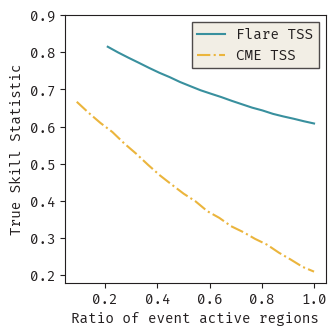

In [49]:
# Plot this now

fig, ax = plt.subplots(1, 1, figsize=(onecolumn, onecolumn))

ax.plot(flare_ratio_values, flare_tss_values, label="Flare TSS", color=colors["blue"])
ax.plot(cme_ratio_values, cme_tss_values, label="CME TSS", color=colors["yellow"], linestyle="-.")

ax.legend(fontsize=10, fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])

ax.set_ylim(0.18, 0.9)

ax.set_xlabel("Ratio of event active regions")
ax.set_ylabel("True Skill Statistic")
plt.tight_layout()

plt.savefig("active_regions_tss.pdf", bbox_inches="tight")

# Distribution of predictions

In [6]:
preds_path = "../out/main_predictions.db"

conn = sqlite3.connect(preds_path)
cur = conn.cursor()

for table in ["flare_forecast", "cme_forecast", "flare_cme_assoc"]:
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_harpnum_idx ON {table}_rotary_transformer_24_predictions (harpnum)")
    cur.execute(f"CREATE INDEX IF NOT EXISTS {table}_run_id_idx ON {table}_rotary_transformer_24_predictions (run_id)")

# Attach ../data/features.db

cur.execute("ATTACH DATABASE '../data/features.db' AS features")

# Delete temp view if exists
cur.execute("DROP TABLE IF EXISTS combined_forecasts")

cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_flare_forecast ON flare_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_cme_forecast ON cme_forecast_rotary_transformer_24_predictions(run_id, harpnum, start);
CREATE INDEX IF NOT EXISTS idx_flare_cme_assoc ON flare_cme_assoc_rotary_transformer_24_predictions(run_id, harpnum, start);

CREATE TEMP TABLE IF NOT EXISTS combined_forecasts AS
WITH unique_keys AS (
    SELECT run_id, harpnum, start, end FROM flare_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM cme_forecast_rotary_transformer_24_predictions
    UNION
    SELECT run_id, harpnum, start, end FROM flare_cme_assoc_rotary_transformer_24_predictions
),
combined_data AS (
    SELECT 
        uk.run_id, 
        uk.harpnum, 
        uk.start,
        uk.end,
        f.pred AS flare_pred, f.target AS flare_target,
        c.pred AS cme_pred, c.target AS cme_target,
        fc.pred AS flare_cme_pred, fc.target AS flare_cme_target,
        s.is_cme_active as base_cme_pred,
        s.is_cme_active as base_flare_cme_pred,
        s.is_active as base_flare_pred
    FROM unique_keys uk
    LEFT JOIN flare_forecast_rotary_transformer_24_predictions f ON uk.run_id = f.run_id AND uk.harpnum = f.harpnum AND uk.start = f.start
    LEFT JOIN cme_forecast_rotary_transformer_24_predictions c ON uk.run_id = c.run_id AND uk.harpnum = c.harpnum AND uk.start = c.start
    LEFT JOIN flare_cme_assoc_rotary_transformer_24_predictions fc ON uk.run_id = fc.run_id AND uk.harpnum = fc.harpnum AND uk.start = fc.start
    INNER JOIN features.T_24_L_24_S_0_2_B_0_OVERLAPS_1_MIN_FLARE_30_dataset_splits s ON uk.harpnum = s.harpnum
)
SELECT * FROM combined_data;
""")

In [7]:
data = pd.read_sql("""
SELECT * FROM combined_forecasts
                    """, conn)

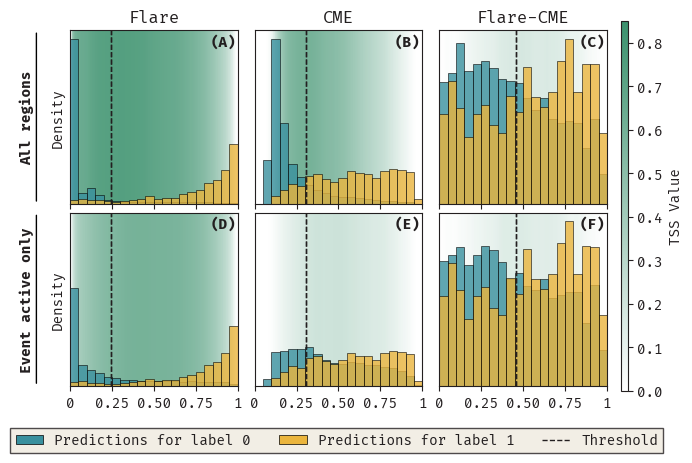

0.0 0.8173643847669605


In [172]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import matplotlib.patches as patches

bins = np.arange(0, 1.01, 0.05)

flare_data = data[~data["flare_target"].isna()].copy()
cme_data = data[~data["cme_target"].isna()].copy()
flare_cme_data = data[~data["flare_cme_target"].isna()].copy()

flare_active_data = flare_data[flare_data["base_flare_pred"] == 1]
cme_active_data = cme_data[cme_data["base_cme_pred"] == 1]
flare_cme_active_data = flare_cme_data[flare_cme_data["base_flare_cme_pred"] == 1]


fig, axes = plt.subplots(2, 3, figsize=(twocolumn, 2 * twocolumn/3), sharex=True, sharey=False, gridspec_kw={"hspace": 0.05, "wspace": 0.1})

# Calculate global TSS range for consistent color mapping across plots
all_tss_values = []

# Define colormap normalization
norm = Normalize(vmin=0, vmax=0.85)
cmap = LinearSegmentedColormap.from_list("custom", ["white", colors["green"]])

# Make a custom colormap going from white to colors["orange"]
ylims = {}

letters = ["A", "B", "C", "D", "E", "F"]
m = 0

for j, all_data in enumerate([[flare_data, cme_data, flare_cme_data], [flare_active_data, cme_active_data, flare_cme_active_data]]):
    for i, (forecast_data, title) in enumerate(zip(all_data, ["Flare", "CME", "Flare-CME"])):
        ax = axes[j,i]
        ax.set_aspect('equal')
        column = f"{title.replace('-', '_').lower()}"

        # Put the letter on top right of plot
        # Anchor top right of text
        ax.text(0.99,0.98, f"({letters[m]})", transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='bold')
        m += 1

        # Plot histograms
        for target in [0, 1]:
            target_data = forecast_data[forecast_data[f"{column}_target"] == target]
            ax.hist(target_data[f"{column}_pred"], bins=bins, alpha=0.8, color=colors["yellow"] if target == 1 else colors["blue"], edgecolor="black", linewidth=0.5, density=True)
            # Plot the threshold
            ax.axvline(thresholds[column], color=colors["black"], linestyle="--", linewidth=1)

            if j == 0:
                ylims[column] = ax.get_ylim()
            else:
                ax.set_ylim(ylims[column])
            
            original_y_max = ax.get_ylim()[1]
        
        # Plot background TSS value coloring
        tss_values = vectorized_true_skill_statistic(forecast_data[f"{column}_target"], forecast_data[f"{column}_pred"], tss_thresholds)
        all_tss_values.extend(tss_values)
        # Create a continuous background color image based on TSS values
        ax.imshow(np.tile(tss_values, (100, 1)), aspect='auto', extent=[0, 1, 0, original_y_max], origin='lower', cmap=cmap, alpha=0.9, zorder=-1, norm=norm)
        
        if j == 0:
            ax.set_title(title)
        #ax.set_xlabel("Prediction")
        ax.set_xlim(0, 1)

        # Remove every tick and label from y axis
        ax.set_yticks([])

axes[0,0].set_ylabel("Density")
axes[1,0].set_ylabel("Density")

for ax in axes[1,:]:
    # Set xticks to 0, 0.25, 0.5, 0.75, 1
    # But for 0 and 1 no decimals
    ax.set_xticks(np.arange(0, 1.01, 0.25))
    ax.set_xticklabels([f"{x:.0f}" if x in [0, 1] else f"{x:.2f}" for x in np.arange(0, 1.01, 0.25)]) 

# plt.tight_layout()

# Adjustments for adding the vertical lines and text
for j, label in enumerate(["All regions", "Event active only"]):
    ax = axes[j, 0]  # Reference to the first plot in each row
    # Use Line2D to draw a vertical line
    # Drawing a line with annotate
    ax.annotate('', xy=(-0.2, 0), xytext=(-0.2 , 1), xycoords='axes fraction', 
                textcoords='axes fraction', arrowprops=dict(arrowstyle="-", color="black"))
    
    # Add vertical text aligned with the line. Adjust x and y values for positioning.
    ax.text(-0.3, 0.5, label, rotation=90, transform=ax.transAxes, verticalalignment='center', horizontalalignment='left', fontweight='bold')

# Adjust layout to accommodate the new text elements
# plt.tight_layout(rect=[0.05, 0, 0.95, 1])

# Create a colorbar with the same normalization and colormap
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])  # Adjust the position and size as needed
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cbar_ax, label='TSS Value')

# Now need a manual legend
# A blue bar for "Predictions for label 0" and a yellow bar for "Predictions for label 1
# Then a dashed line for the threshold

# Create custom legend handles using rectangles for bars
legend_elements = [
    patches.Patch(facecolor=colors["blue"], edgecolor='black', linewidth=0.5, label='Predictions for label 0'),
    patches.Patch(facecolor=colors["yellow"], edgecolor='black', linewidth=0.5, label='Predictions for label 1'),
    Line2D([0], [0], color=colors["black"], lw=1, linestyle='--', label='Threshold')
]

# Place the legend on the figure
fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.51, -0.05), loc='lower center', fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])
plt.savefig("predictions_distributions.pdf", bbox_inches="tight")

plt.show()


print(min(all_tss_values), max(all_tss_values))


# Plot example region predictions

In [172]:
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

def plot_region_cmes(harpnum1, harpnum2, harpnum3):
    fig, axes = plt.subplots(1, 3, figsize=(twocolumn, twocolumn/3), sharey=True, sharex=False, gridspec_kw={"wspace": 0.2})

    pre_titles = [
        "Event active",
        "Event active",
        "Non event active"
    ]

    for i, harpnum in enumerate([harpnum1, harpnum2, harpnum3]):
        ax = axes[i]
        hdata = data[data["harpnum"] == harpnum].copy()

        hruns = hdata["run_id"].unique()

        hdata = hdata[hdata["run_id"] == hruns[0]]

        hdata["end"] = pd.to_datetime(hdata["end"])

        dates, predictions, labels = hdata[["end", "cme_pred", "cme_target"]].dropna().values.T

        ax.plot(dates, labels, color=colors["blue"], linewidth=2, solid_capstyle='round')
        ax.plot(dates, predictions, color=colors["yellow"], linewidth=2, solid_capstyle='round')

        ax.set_title(f"{pre_titles[i]}", fontsize=10, rotation=-90,ha='left', va='top', y=0.96, x=1.01)

        # Set secondary title
        ax.text(0, 1.01, f"HARPNUM: {harpnum}", transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom', fontsize=10, fontweight='bold')

    # Format to one day

    for ax in axes:
        ax.set_ylim(-0.05,1.05)
        # Plot threshold

        ax.axhline(thresholds["cme"], color=colors["black"], linestyle="--", linewidth=2, zorder=-1)

        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

        ax.set_xticklabels([])

        # Set y ticks to 0, threshold, 1
        # Format to 2 decimal places
        ax.set_yticks([0, thresholds["cme"], 1])
        ax.set_yticklabels([f"{x:.2f}" if x not in [0,1] else f"{x}" for x in [0, thresholds["cme"], 1] ])


    # Now need a manual legend
    legend_elements = [
        Line2D([0], [0], color=colors["blue"], lw=2, label='Target'),
        Line2D([0], [0], color=colors["yellow"], lw=2, label='Prediction'),
        Line2D([0], [0], color=colors["black"], lw=2, linestyle='--', label='Threshold')
    ]

    # Place the legend on the figure
    fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.5, -0.1), loc='lower center', fancybox=False, facecolor=colors["beige"], edgecolor=colors["black"])


    return fig

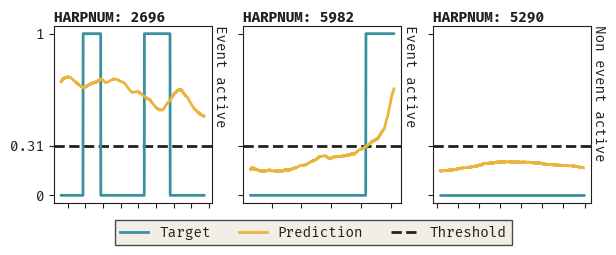

In [174]:
fig = plot_region_cmes(2696, 5982, 5290)

plt.savefig("cme_predictions_example.pdf", bbox_inches="tight")